<a href="https://colab.research.google.com/github/pkdyn/satireNews/blob/main/satireNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after","afterwards", "again", "against",
             "all", "am", "an", "and", "any", "are", "as", "at","almost",
             "along","already","although", "among", "amongst", "always",
             "another", "anyhow","anyone","anything","anyway","anywhere", 
             "be", "because", "been", "before", "being", "below","beforehand", "beside", "besides",
             "between", "both", "but", "by", "could", "did", "do","couldnt",
             "does", "doing", "during", "each", "few", "for","done","detail","even","get","go","goes", 
             "from", "further", "had", "has", "have", "having","hasnt","hence",
             "he", "hed", "hes", "her", "here", "heres", "hers","hereafter","hereby","herein","hereupon",
             "herself", "him", "himself", "his", "how","hows", "i", "id","however",
             "ill", "im", "ive", "if", "in", "into","is", "it", "its","ie","inc","indeed",
             "itself","lets", "me", "more", "most", "my","myself", "nor","ltd","less","many","may","must",
              "meanwhile","might","mine","namely","neither","nevertheless","now","maybe",
             "of", "on", "once", "only", "or", "other", "ought","off","often","others","otherwise",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she","perhaps","please","per","seem","seems","seemed","seeming",
             "shed", "shell", "shes", "should","since", "so", "some", "such", "than","rather","several","serious","show","shows",
             "that", "thats", "the", "their", "theirs", "them", "themselves","somehow","sometimes","still",
             "then","there", "theres", "these", "they", "theyd", "theyll","thereafter","thereby","therefore","therein",
             "theyre","theyve", "this", "those", "though","to", "too","through","throughout","thru","thus","together",
             "under", "until","up", "very", "was", "we", "wed", "well",
             "were", "weve", "were","what", "whats", "when", "whens", "where",
             "whereas","whereby","whereupon","whether","whoever","whose","will"
             "wheres", "which", "while","who", "whos", "whom", "why","whys",
             "with", "would", "you", "youd","youll", "youre", "youve", "your","yet",
             "yours", "yourself","yourselves"]

table = str.maketrans('', '', string.punctuation)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.zip\
    -O /tmp/glove.zip


--2021-07-19 17:16:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112372936 (107M) [application/zip]
Saving to: ‘/tmp/glove.zip’

/tmp/glove.zip      100%[===================>] 107.17M   177MB/s    in 0.6s    

2021-07-19 17:16:56 (177 MB/s) - ‘/tmp/glove.zip’ saved [112372936/112372936]



In [4]:

import numpy as np
import os
import zipfile

local_zip = '/tmp/glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/glove')
zip_ref.close()

glove_embeddings = dict()
f = open('/tmp/glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

In [5]:
print('Loaded %s word vectors.' % len(glove_embeddings))

Loaded 1193514 word vectors.


In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json
  
import json
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []

for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

print(len(sentences))

--2021-07-19 17:17:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-07-19 17:17:25 (243 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]

26709


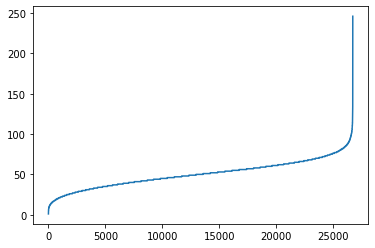

In [7]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)
import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.show()

In [9]:
vocab_size = 12500
embedding_dim = 25
max_length = 85
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 21500

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

(12000.0, 14000.0, 0.8, 1.0)

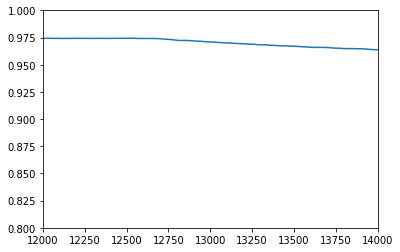

In [10]:
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
  xs.append(index)
  cumulative_x.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)

import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(12,2))
#ax.spines['top'].set_visible(False)

plt.plot(cumulative_x, cumulative_y)
plt.axis([12000, 14000, 0.8, 1])
#plt.margins(x=0, y=None, tight=True)
#plt.axis([0, 26000, 0, 1])
#plt.fill(ys)

In [11]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [12]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [14]:
def make_model(learning_rate=0.001, size=24):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True, dropout=0.15) ),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.15)),
      tf.keras.layers.Dense(size, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  adam = tf.keras.optimizers.Adam(learning_rate)
  model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
  return model


Epoch 1/5
672/672 [==============================] - 25s 21ms/step - loss: 0.5808 - accuracy: 0.6962 - val_loss: 0.5451 - val_accuracy: 0.7245
Epoch 2/5
672/672 [==============================] - 12s 18ms/step - loss: 0.5185 - accuracy: 0.7457 - val_loss: 0.5476 - val_accuracy: 0.7189
Epoch 3/5
672/672 [==============================] - 13s 19ms/step - loss: 0.4989 - accuracy: 0.7576 - val_loss: 0.4909 - val_accuracy: 0.7585
Epoch 4/5
672/672 [==============================] - 13s 20ms/step - loss: 0.4861 - accuracy: 0.7624 - val_loss: 0.4863 - val_accuracy: 0.7618
Epoch 5/5
672/672 [==============================] - 14s 20ms/step - loss: 0.4750 - accuracy: 0.7743 - val_loss: 0.4830 - val_accuracy: 0.7573
Epoch 1/5
672/672 [==============================] - 20s 23ms/step - loss: 0.6515 - accuracy: 0.6178 - val_loss: 0.6049 - val_accuracy: 0.6758
Epoch 2/5
672/672 [==============================] - 14s 20ms/step - loss: 0.5950 - accuracy: 0.6862 - val_loss: 0.5847 - val_accuracy: 0.6957

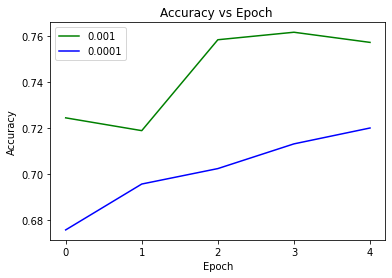

In [15]:
num_epochs = 5
model = make_model(learning_rate=0.001)
history_001 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
model = make_model(learning_rate=0.0001)
history_0001 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
epochs = np.arange(5)
val_001 = history_001.history['val_accuracy']
val_0001 = history_0001.history['val_accuracy']
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_001, color='green', linestyle='solid', label='0.001')
plt.plot(epochs, val_0001, color='blue', linestyle='solid', label='0.0001')
plt.title('Accuracy vs Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()

Epoch 1/15
672/672 [==============================] - 20s 22ms/step - loss: 0.5840 - accuracy: 0.6926 - val_loss: 0.5424 - val_accuracy: 0.7236
Epoch 2/15
672/672 [==============================] - 13s 20ms/step - loss: 0.5278 - accuracy: 0.7361 - val_loss: 0.5065 - val_accuracy: 0.7547
Epoch 3/15
672/672 [==============================] - 14s 20ms/step - loss: 0.5043 - accuracy: 0.7507 - val_loss: 0.4986 - val_accuracy: 0.7587
Epoch 4/15
672/672 [==============================] - 13s 20ms/step - loss: 0.4853 - accuracy: 0.7677 - val_loss: 0.4890 - val_accuracy: 0.7633
Epoch 5/15
672/672 [==============================] - 14s 20ms/step - loss: 0.4733 - accuracy: 0.7740 - val_loss: 0.4776 - val_accuracy: 0.7656
Epoch 6/15
672/672 [==============================] - 14s 20ms/step - loss: 0.4622 - accuracy: 0.7802 - val_loss: 0.4803 - val_accuracy: 0.7704
Epoch 7/15
672/672 [==============================] - 13s 20ms/step - loss: 0.4554 - accuracy: 0.7856 - val_loss: 0.4730 - val_accuracy:

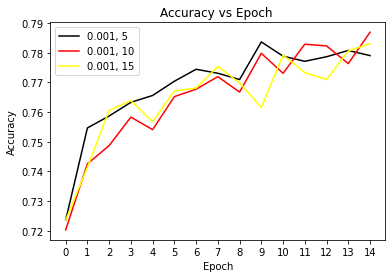

In [17]:
num_epochs = 15
model = make_model(learning_rate=0.001, size=5)
history_001_5 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
model = make_model(learning_rate=0.001, size=10)
history_001_10 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
model = make_model(learning_rate=0.001, size=15)
history_001_15 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
epochs = np.arange(15)
val_001_5 = history_001_5.history['val_accuracy']
val_001_10= history_001_10.history['val_accuracy']
val_001_15= history_001_15.history['val_accuracy']
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_001_5, color='black', linestyle='solid', label='0.001, 5')
plt.plot(epochs, val_001_10, color='red', linestyle='solid', label='0.001, 10')
plt.plot(epochs, val_001_15, color='yellow', linestyle='solid', label='0.001, 15')
plt.title('Accuracy vs Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint(
"xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5", 
save_best_only=True, 
monitor="val_accuracy" 
)
num_epochs = 30
model = make_model(learning_rate=0.001, size=5)
history_001_10 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), 
                            callbacks=[checkpoint])



Epoch 1/30
672/672 [==============================] - 20s 23ms/step - loss: 0.5793 - accuracy: 0.6993 - val_loss: 0.5367 - val_accuracy: 0.7285
Epoch 2/30
672/672 [==============================] - 13s 20ms/step - loss: 0.5245 - accuracy: 0.7424 - val_loss: 0.5124 - val_accuracy: 0.7445
Epoch 3/30
672/672 [==============================] - 13s 19ms/step - loss: 0.5043 - accuracy: 0.7553 - val_loss: 0.4961 - val_accuracy: 0.7541
Epoch 4/30
672/672 [==============================] - 12s 18ms/step - loss: 0.4878 - accuracy: 0.7620 - val_loss: 0.4906 - val_accuracy: 0.7602
Epoch 5/30
672/672 [==============================] - 12s 18ms/step - loss: 0.4751 - accuracy: 0.7718 - val_loss: 0.5036 - val_accuracy: 0.7558
Epoch 6/30
672/672 [==============================] - 12s 19ms/step - loss: 0.4671 - accuracy: 0.7772 - val_loss: 0.4693 - val_accuracy: 0.7758
Epoch 7/30
672/672 [==============================] - 14s 20ms/step - loss: 0.4598 - accuracy: 0.7828 - val_loss: 0.4802 - val_accuracy:

In [31]:
test_sentences = [
"NFT conversations growing in India: Twitter", 
"After conquering Earth, Bezos eyes new frontier in space", 
"Google wants people in office, despite productivity gains at home",
"Indian Navy ship exercises with French Navy", 
"Microsoft Exchange email hack was caused by China, US says", 
"Russia test fires Zircon hypersonic cruise missile", 

"Nobel Prize-winning fighter pilot with PhD almost meets requirements for entry level job", 
"Struggling Tech Start-up Almost Desperate Enough To Start Making Actual Product", 
"Jeff Bezos to step down in five to ten days, or overnight with Prime",  
"Serbia Deploys Peacekeeping Forces To U.S.", 
"Danes, Dutch form nation after growing too tired to explain they’re different countries", 
"China unveils new tourism slogan, ‘Come and you’ll never be able to leave'"

]

sequences = tokenizer.texts_to_sequences(test_sentences)
test_pad = pad_sequences(sequences, maxlen=max_length,padding=padding_type, truncating=trunc_type)
print(model.predict(test_pad))

[[0.00907639]
 [0.4444482 ]
 [0.4079649 ]
 [0.08048009]
 [0.10359509]
 [0.06824059]
 [0.98383266]
 [0.99204016]
 [0.9822075 ]
 [0.83978474]
 [0.98845404]
 [0.95324624]]
